In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import accuracy_score
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
class RobustCNN(nn.Module):
    """
    A more robust CNN architecture for MNIST classification.
    (This must be the EXACT same architecture as the one you trained and saved)
    """
    def __init__(self):
        super(RobustCNN, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.adaptive_pool(x)
        x = self.classifier(x)
        return x

def get_data_loaders(batch_size):
    """Prepares and returns the MNIST DataLoaders."""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)
    return train_loader, test_loader


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import accuracy_score

In [4]:
# --- Configuration ---
MODEL_PATH = os.path.join("models", "mnist_robust_cnn.pth")
BATCH_SIZE = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def get_all_predictions(model, data_loader, device):
    """Runs inference on the entire dataset and returns predictions and labels."""
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            preds = output.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    return np.array(all_preds), np.array(all_targets)

In [5]:
class FairnessAnalyzer:
    """Analyzes model fairness on the MNIST dataset using synthetic attributes."""
    def __init__(self, predictions, true_labels, image_data):
        self.predictions = predictions
        self.true_labels = true_labels
        self.image_data = image_data.numpy().astype(np.float32) / 255.0

    def _generate_synthetic_attributes(self):
        """Creates synthetic groups based on image/label characteristics to probe for bias."""
        complexity_map = {
            'simple': [1, 7],
            'medium': [0, 2, 3, 5],
            'complex': [4, 6, 8, 9]
        }
        complexity_groups = []
        for label in self.true_labels:
            if label in complexity_map['simple']:
                complexity_groups.append('simple')
            elif label in complexity_map['medium']:
                complexity_groups.append('medium')
            else:
                complexity_groups.append('complex')

        quality_groups = []
        for img in self.image_data:
            avg_intensity = np.mean(img)
            if avg_intensity < 0.1:
                quality_groups.append('low_intensity')
            elif avg_intensity < 0.2:
                quality_groups.append('med_intensity')
            else:
                quality_groups.append('high_intensity')
        
        return {
            'Digit Complexity': np.array(complexity_groups),
            'Image Intensity': np.array(quality_groups)
        }

    def _display_fairness_metrics(self, group_accuracies, group_name):
        """Prints a formatted report of fairness metrics for a given attribute."""
        print(f"\n--- Fairness Metrics for: {group_name} ---")
        accuracies = list(group_accuracies.values())
        max_acc, min_acc = (max(accuracies), min(accuracies)) if accuracies else (0, 0)
        fairness_gap = max_acc - min_acc
        
        for group, acc in group_accuracies.items():
            print(f"  - Group '{group}': Accuracy = {acc:.2%}")
        
        print(f"\n  Performance Gap (Max - Min Accuracy): {fairness_gap:.2%}")
        if fairness_gap > 0.02:
            print("  ⚠️ POTENTIAL BIAS DETECTED: A notable performance gap exists between groups.")
        else:
            print("  ✅ No significant performance gap detected.")
        print("-" * (len(group_name) + 26))

    def _plot_group_performance(self, group_accuracies, group_name):
        """Visualizes performance differences across groups."""
        groups, accuracies = list(group_accuracies.keys()), list(group_accuracies.values())
        plt.figure(figsize=(8, 5))
        bars = plt.bar(groups, accuracies, color=sns.color_palette("viridis", len(groups)))
        plt.ylabel('Accuracy')
        plt.title(f'Model Accuracy by {group_name}')
        plt.ylim(min(accuracies) - 0.01 if accuracies else 0.95, max(accuracies) + 0.01 if accuracies else 1.0)
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2%}', va='bottom', ha='center')
        plt.tight_layout()
        plt.show()

    def run_analysis(self):
        """Main method to run the complete fairness analysis."""
        print("=== Starting Model Fairness Analysis ===")
        print("Generating synthetic attributes to probe for potential biases...")
        attributes = self._generate_synthetic_attributes()
        for attr_name, group_labels in attributes.items():
            unique_groups = sorted(np.unique(group_labels))
            group_accuracies = {
                group: accuracy_score(self.true_labels[group_labels == group], self.predictions[group_labels == group])
                for group in unique_groups if np.sum(group_labels == group) > 0
            }
            self._display_fairness_metrics(group_accuracies, attr_name)
            self._plot_group_performance(group_accuracies, attr_name)
        print("\n=== Analysis Complete ===")

Loading pre-trained model from models\mnist_robust_cnn.pth
Running model inference on the entire test set...
=== Starting Model Fairness Analysis ===
Generating synthetic attributes to probe for potential biases...

--- Fairness Metrics for: Digit Complexity ---
  - Group 'complex': Accuracy = 98.90%
  - Group 'medium': Accuracy = 99.31%
  - Group 'simple': Accuracy = 99.21%

  Performance Gap (Max - Min Accuracy): 0.41%
  ✅ No significant performance gap detected.
------------------------------------------


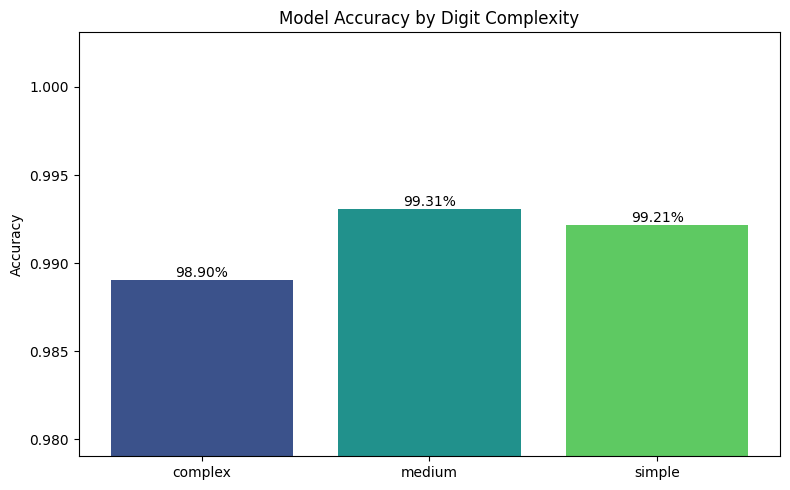


--- Fairness Metrics for: Image Intensity ---
  - Group 'high_intensity': Accuracy = 98.52%
  - Group 'low_intensity': Accuracy = 98.73%
  - Group 'med_intensity': Accuracy = 99.32%

  Performance Gap (Max - Min Accuracy): 0.81%
  ✅ No significant performance gap detected.
-----------------------------------------


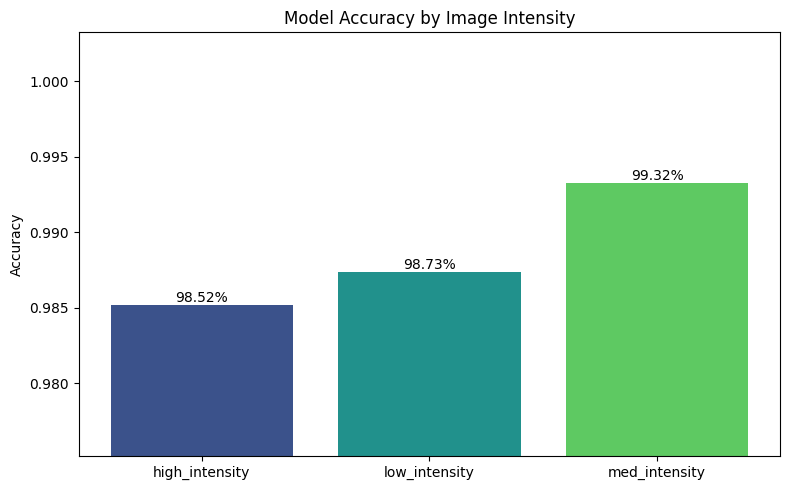


=== Analysis Complete ===


In [6]:
# ==============================================================================
# Main execution block
# ==============================================================================

if not os.path.exists(MODEL_PATH):
    print(f"Error: Model file not found at '{MODEL_PATH}'")
    print("Please ensure you have run your training notebook (Arya.ipynb) first.")
else:
    # 1. Load the trained model
    print(f"Loading pre-trained model from {MODEL_PATH}")
    model = RobustCNN().to(device)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    
    # 2. Get the test data
    _, test_loader = get_data_loaders(BATCH_SIZE)
    raw_test_images = test_loader.dataset.data
    
    # 3. Get all model predictions for the test set
    print("Running model inference on the entire test set...")
    predictions, true_labels = get_all_predictions(model, test_loader, device)
    
    # 4. Initialize and run the analyzer
    analyzer = FairnessAnalyzer(predictions, true_labels, raw_test_images)
    analyzer.run_analysis()